In [1]:
%reset -f
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.widgets as wid
import astropy
from astropy.io import fits
import regions
import skyfield as sky
#from xpbin import xpbin as _xpbin
import sys
import os
#sys.path.insert(0,'/home/jacob/Downloads/heasoft-6.31.1/x86_64-pc-linuc-gnu-libc2.31/lib')
import random
#import heasoftpy as hsp
sys.path.insert(0,os.path.abspath('/home/jacob/data/HerX-1/02003801'))
sys.path.insert(0,os.path.abspath('/home/jacob/data/HerX-1/02004001'))
sys.path.insert(0,os.path.abspath('/home/jacob/data/HerX-1/01001899'))
sys.path.insert(0,os.path.abspath('/home/jacob/data/HerX-1/02004101'))
sys.path.insert(0,os.path.abspath('/home/jacob/data/HerX-1/02003901'))
sys.path.insert(0,os.path.abspath('/home/jacob/data/02005801'))
sys.path.insert(0,os.path.abspath('/home/jacob/ixpeobssimdata'))
#import event_l1, event_l2, hk, auxil
import math
#from ixpeobssim.utils.environment import PYXSPEC_INSTALLED
#if PYXSPEC_INSTALLED:
#    import ixpeobssim.evt.xspec_.py as xspec
import pandas as pd
import ixpeobssim as ixpe 
from scipy import optimize as opt

#import pickle
from scipy import pi as pi
from scipy.special import jn  as jn
import scipy.interpolate, scipy.misc
import IPython.display as ipd
from scipy import signal
from scipy.interpolate import UnivariateSpline,InterpolatedUnivariateSpline
import xlsxwriter
import openpyxl
from glob import glob

## Input Files

In [2]:
path = '/home/jacob/data/HER_X-1/02004101/'

orbdatafile = '/home/jacob/data/HER_X-1/RFiles/herx1.fits'
modulationfiles = sorted(glob(f'/home/jacob/data/HER_X-1/RFiles//ixpe_d*mfact_02.fits'))

BinaryCorrection = True
datafiles = sorted(glob(f'{path}/event_l2/*barycorr.fits*'))
print(datafiles)
# set orbital params
SOURCENAME = 'herx1'
OBSID = '02004101'
SOURCERAD = 20
CenterX,CenterY = 290,308

['/home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det1_evt2_v01_barycorr.fits', '/home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det2_evt2_v01_barycorr.fits', '/home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det3_evt2_v01_barycorr.fits']


## Import Orbital Data

In [3]:
orbdataopen = astropy.io.fits.open(orbdatafile)
orbdata = orbdataopen[1].data
spindata = orbdataopen[2].data
orbdataopen.close()

RA = orbdata['RA']
DEC = orbdata['DEC']
BINARY = orbdata['BINARY']
PBINARY = orbdata['PBINARY']
PBDOT = orbdata['PBDOT']
BINARYEPOCH = orbdata['BINARYEPOCH']
AXSINI = orbdata['AXSINI']
ECCENTRICITY = orbdata['ECCENTRICITY']
EGRESS = orbdata['EGRESS']
INGRESS = orbdata['INGRESS']
OMEGA = orbdata['PERIAPSE']

print(orbdatafile)

/home/jacob/data/HER_X-1/RFiles/herx1.fits


## IMPORT MODULATION FACTORS

In [4]:

for i,f in enumerate(modulationfiles):
    detcode = int(f[f.find('ixpe_d')+6])
    print(i,f,detcode)
    with fits.open(modulationfiles[detcode-1]) as hdu:
        if i == 0:
            moddata = hdu[1].data
            moddetector = np.full(len(hdu[1].data),detcode)
            hdu.close()
        else:
            moddata = np.append(moddata,hdu[1].data)
            moddetector = np.append(moddetector,np.full(len(hdu[1].data),detcode))
            hdu.close()
moddata = np.array([moddata['ENERG_LO'],moddata['ENERG_HI'],moddata['SPECRESP'],moddetector]).T
moddata = pd.DataFrame(moddata,columns=['ENERG_LO', 'ENERG_HI','SPECRESP','detector'])
display(moddata)

0 /home/jacob/data/HER_X-1/RFiles/ixpe_d1_20170101_mfact_02.fits 1
1 /home/jacob/data/HER_X-1/RFiles/ixpe_d2_20170101_mfact_02.fits 2
2 /home/jacob/data/HER_X-1/RFiles/ixpe_d3_20170101_mfact_02.fits 3


,ENERG_LO,ENERG_HI,SPECRESP,detector
0,1.00,1.04,0.012944,1.0
1,1.04,1.08,0.012779,1.0
2,1.08,1.12,0.013067,1.0
3,1.12,1.16,0.013809,1.0
4,1.16,1.20,0.015005,1.0
...,...,...,...,...
820,11.80,11.84,0.198006,3.0
821,11.84,11.88,0.196821,3.0
822,11.88,11.92,0.195631,3.0
823,11.92,11.96,0.194435,3.0


## GET Barycorrected DATA

In [5]:
print(datafiles)
#/mnt/c/Users/jacob/Desktop/VelaX1Sim/Black/

['/home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det1_evt2_v01_barycorr.fits', '/home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det2_evt2_v01_barycorr.fits', '/home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det3_evt2_v01_barycorr.fits']


## Import Data from Detectors

In [6]:
for i,f in enumerate(datafiles):
    detcode = int(f[f.find('det')+3])
    print(i,f,detcode)
    with fits.open(datafiles[detcode-1]) as hdu:
        if (i ==0):
            MJDREFI=hdu[0].header['MJDREFI']
            MJDREFF=hdu[0].header['MJDREFF']
            LIVETIME = hdu[0].header['LIVETIME']
            events = hdu[1].data
            detector = np.full(len(hdu[1].data),detcode)
            hdu.close()
        else:
            events = np.append(events,hdu[1].data)
            detector = np.concatenate((detector,np.full(len(hdu[1].data),i+1)))
            hdu.close()
#X = evtlist['X']
#Y = evtlist['Y']
#Ch = evtlist['PI']
path = '/mnt/c/Users/jacob/Desktop'
os.makedirs(f'{path}/plots',0o755, exist_ok=True)

0 /home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det1_evt2_v01_barycorr.fits 1
1 /home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det2_evt2_v01_barycorr.fits 2
2 /home/jacob/data/HER_X-1/02004101//event_l2/ixpe02004101_det3_evt2_v01_barycorr.fits 3


## SETUP BACKGROUND AND ENERGY LIMITS

In [7]:
coords = pd.read_csv('/home/jacob/data/HER_X-1/CoordinatesofNS.txt',delim_whitespace=True)
CenterX, CenterY= coords['X'].loc[coords['OBS_ID'] == float(OBSID)].mean(),coords['Y'].loc[coords['OBS_ID'] == float(OBSID)].mean()
print(CenterX,CenterY)
radius = np.sqrt(((events['X']-CenterX)**2)+((events['Y']-CenterY)**2))

Bounds = (events['PI']>49) & (events['PI']<=200) & (radius<SOURCERAD)
Background = (events['PI']>49) & (events['PI']<=200) & (radius<4*SOURCERAD) & (radius>2*SOURCERAD)


evtback = events[Background]
events = events[Bounds]
print(len(events))
detback = detector[Background]
detector = detector[Bounds]

299.0 307.0
923799


## Binary Correction

60150.533530508386


,Barycentered Times,CH,U,Q,W_mom,X,Y,Time,Phase,detector,OrbitalCorrectedTime
0,2.070604e+08,57.0,-2.208741,0.301886,0.182102,312.104004,305.684906,21.328255,0.232103,1,21.328255
1,2.070604e+08,70.0,-1.518409,-1.193056,0.195905,296.962982,305.013916,22.259182,0.984243,1,22.259182
2,2.070604e+08,95.0,0.517667,-1.974652,0.490637,287.587006,307.686920,23.548726,0.026125,1,23.548726
3,2.070604e+08,118.0,-1.653009,-1.182928,0.589152,298.842987,298.696899,24.011062,0.399669,1,24.011062
4,2.070604e+08,54.0,1.559736,-1.087993,0.091830,295.175995,308.626923,24.607353,0.881440,1,24.607353
...,...,...,...,...,...,...,...,...,...,...,...
923794,2.074910e+08,63.0,-0.076617,2.054827,0.187536,298.676758,302.997559,430584.325295,0.371358,3,430584.325295
923795,2.074910e+08,84.0,1.609516,1.093525,0.036422,297.992737,309.458557,430585.326179,0.180019,3,430585.326179
923796,2.074910e+08,89.0,0.522674,-1.860802,0.381745,301.344757,302.797546,430585.771121,0.539509,3,430585.771121
923797,2.074910e+08,125.0,-1.270131,1.589389,0.190531,294.281738,305.489563,430586.155911,0.850399,3,430586.155911


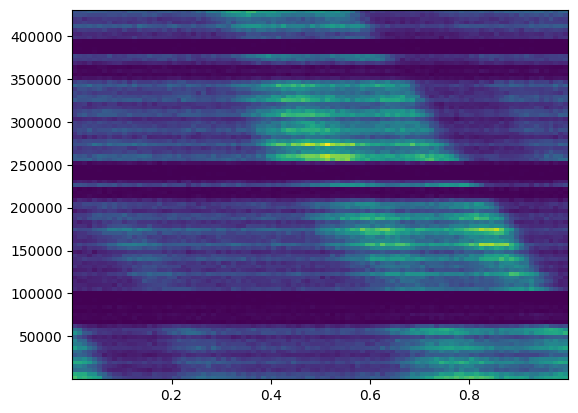

In [8]:
  
if BinaryCorrection:
#os.system('[ -f %s.fits.gz ] || curl https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/%s.fits.gz --output %s.fits.gz' % (SOURCENAME,SOURCENAME,SOURCENAME))
#    with fits.open('%s.fits.gz' % SOURCENAME)  as hdu:
#        orbitdata=hdu['Orbital Elements'].data
#        spindata=hdu['PSR_HIST'].data
    day=3600*24



    TPIOVER2O=orbdata['BINARYEPOCH']-2400000.5
    PORB=orbdata['PBINARY']*day
    PORBDOT=orbdata['PBDOT']
    ECCENTRICITY=orbdata['ECCENTRICITY']
    OMEGA=orbdata['PERIAPSE']
    ASINIOVERC=orbdata['AXSINI']
    NUORB=1/PORB
    NUORBDOT=-1/PORB/PORB*PORBDOT
    met0=events['TIME'].min()##evtlist['TIME'].min()
    MJDSTART=MJDREFF+MJDREFI+met0/day
    print(MJDSTART)
    NU=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FREQUENCY'])
    NUDOT=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FDOT'])
    TREFNU=MJDSTART
    torb=((MJDREFF+MJDREFI)+events['TIME']/day-TPIOVER2O)*day##((MJDREFF+MJDREFI)+evtlist['TIME']/day-TPIOVER2O)*day
    phaseorb=(0.25+torb*(NUORB+torb*NUORBDOT/2))                    
    orbtime=ASINIOVERC*((np.sin(2*np.pi*phaseorb)-np.sin(np.pi/2))-
                    0.5*ECCENTRICITY*(np.sin(4*np.pi*phaseorb-np.radians(OMEGA))-
                                        np.sin(np.pi/2-np.radians(OMEGA))))
    deltat=events['TIME']-orbtime-met0#evtlist['TIME']-orbtime-met0
    freqtst=NU
    if (NUDOT==0) & (MJDSTART < spindata['BARYTIME'].max()):
        _ii=spindata['BARYTIME']>59000
        nufunk=InterpolatedUnivariateSpline(spindata['BARYTIME'][_ii],spindata['FREQUENCY'][_ii],k=2)
        nudd=nufunk.derivatives(MJDSTART)
        NU=nudd[0]
        NUDOT=nudd[1]/day
        NUDDOT=nudd[2]/day/day
    elif (NUDOT==0) & (MJDSTART > spindata['BARYTIME'].max()):
        NU = spindata['FREQUENCY'][-1]
        #NUDOT = spindata['FDOT'][-1]
        NUDDOT = 0
    else:
        NUDDOT=0

else:
    day=3600*24
    PEPOCH=60022.5116087025740000
    met0=events['TIME'].min()
    MJDSTART=MJDREFF+MJDREFI+met0/day
    deltat=events['TIME']-events['TIME'].min()
    NU=spindata['FREQUENCY'].mean()#0.807911292#0.14328211701342042 # guess for PSR frequency
    #NU-=0.91e-3
    
#Adjust NU + (x) until the 2dhist looks aligned

adjustment = 0#1e-6#0#5e-5#1e-6#1e-7
#NU = 3.52783569E-3
#NU = 0.1363729749
NUDOT = spindata['FDOT'].mean()
#NUDOT = 0.543638e-13
NUDDOT = 0
phase=np.mod(deltat*((NU+adjustment)+0.5*deltat*(NUDOT*deltat*NUDDOT*0.3333333)),1)


df = np.array([events['TIME'],events['PI'],events['U'],events['Q'],events['W_MOM'],events['X'],events['Y']]).T
#df = df.byteswap().newbyteorder()

df = pd.DataFrame(df,columns=['Barycentered Times','CH','U','Q','W_mom','X','Y'])
df['Time'] = deltat
df['Phase'] = phase
df['detector'] = detector
df['OrbitalCorrectedTime'] = df['Time']

bindata=plt.hist2d(df['Phase'],df['Time'],bins=100)
plt.savefig(f'{path}/plots/BeginningPeriodCorrection.jpg')

display(df)
#for i in range(1,4):
#    print(i)
#    df.loc[df['detector']==i].to_csv(f'/home/jacob/Desktop/{OBSID}dataframeDetector{i}.csv',sep=',',header=True,mode='w',index=False,columns=['Barycentered Times','OrbitalCorrectedTime','Phase','X','Y'])

In [9]:
NU += adjustment #1e-6

## Find The New Period

In [10]:
def FindPeriod(adjustment):
    phase=np.mod(deltat*((NU+adjustment)+0.5*deltat*(NUDOT*deltat*NUDDOT*0.3333333)),1)
    PulseP = np.histogram(phase,bins=100)
    PF = (PulseP[0].max()-PulseP[0].min())/(PulseP[0].max()+PulseP[0].min())
    return 1/PF
bnds = [(-1e-4,1e-4)]
initialguess=[0]
res = opt.minimize(FindPeriod,initialguess,method='nelder-mead',bounds = bnds)
NU += res.x
print(res.x)
print(NU)
#NU += 1e-7

[1.08625889e-06]
[0.80794822]


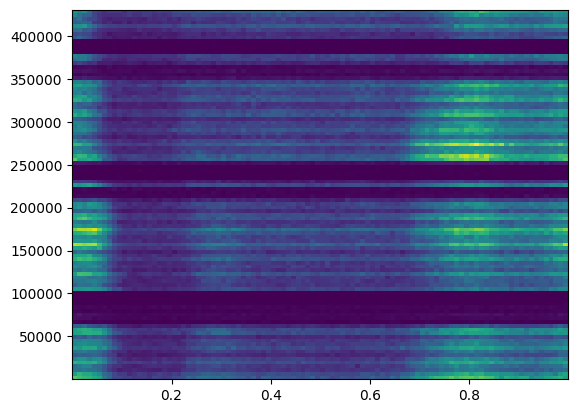

In [11]:
phase=np.mod(deltat*((NU)+0.5*deltat*(NUDOT*deltat*NUDDOT*0.3333333)),1)
df['Phase'] = phase
bindata=plt.hist2d(df['Phase'],df['Time'],bins=100)
plt.savefig(f'{path}/plots/FinalPeriodCorrection.jpg')


In [12]:
print(NU,NUDOT)

[0.80794822] 0.0


## Pulse Profile

In [13]:
PulseP = np.histogram(phase,bins=100)
print((PulseP[0].max()-PulseP[0].min())/(PulseP[0].max()+PulseP[0].min()))

0.6001708266109899


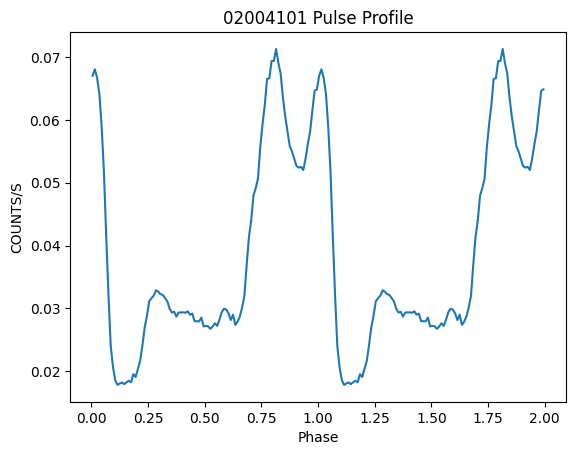

In [14]:
Counts = PulseP[0]
P = []

CenterofBins = (PulseP[1][:-1] + PulseP[1][1:])/2

PulseProfiledf = pd.DataFrame()
PulseProfiledf['Phase'] = CenterofBins
PulseProfiledf['Counts'] = PulseP[0]
#PulseProfiledf.to_csv('/home/jacob/data/simulation/velax1/PulseProfile.csv', sep =',',header = True,index=False)

CenterofBins_ = np.append(CenterofBins,CenterofBins+1)
PulseP_ = np.append(PulseP[0],PulseP[0])
    
plt.figure()
plt.plot(CenterofBins_,PulseP_/LIVETIME)
plt.xlabel('Phase')
plt.ylabel('COUNTS/S')
plt.title(f'{OBSID} Pulse Profile')
#plt.ylim(0,0.06)
fig1 = plt.gcf()
plt.show
fig1.savefig(f'{path}/plots/PulseProfile.jpg')


## Light Curve

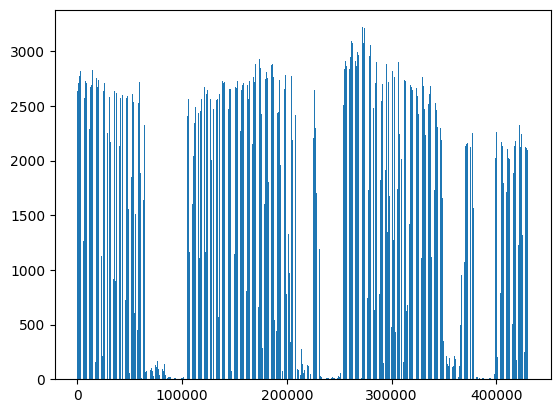

In [15]:
binwidth = 500
lightcurve = plt.hist(df['Time'], bins = range(0,int(df['Time'].max()),binwidth) )

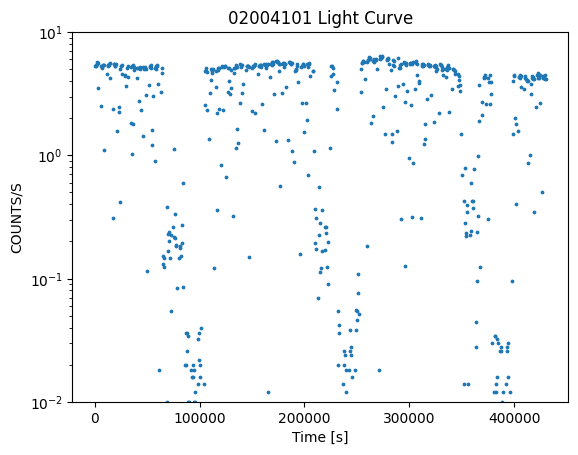

In [16]:
Counts = lightcurve[0]
CenterofLCurveBins = (lightcurve[1][:-1] + lightcurve[1][1:])/2

plt.figure()
plt.scatter(CenterofLCurveBins,Counts/binwidth,s=3)
plt.xlabel('Time [s]')
plt.ylabel('COUNTS/S')
plt.title(f'{OBSID} Light Curve')
plt.ylim(0.01,10)
plt.yscale('log')
fig1 = plt.gcf()
plt.show
fig1.savefig(f'{path}/plots/LightCurve.jpg')

#NOTE for later, the lowered bits are caused by off times within the 250s bins, use the ontime columns to rectify


## Import ARF and RMF Files

In [17]:
ARFfiles = sorted(glob(f'/home/jacob/data/HER_X-1/RFiles/*.arf'))

for i,f in enumerate(ARFfiles):
    detcode = int(f[f.find('ixpe_d')+6])
    print(i,f,detcode)
    with fits.open(ARFfiles[detcode-1]) as hdu:
        if (i ==0):
            Response = hdu[1].data
            detector = np.full(len(hdu[1].data),detcode)
        else:
            Response = np.append(Response,hdu[1].data)
            detector = np.concatenate((detector,np.full(len(hdu[1].data),i+1)))

Response = np.array([Response['ENERG_LO'].flatten(),Response['ENERG_HI'].flatten(),Response['SPECRESP'].flatten()]).T
#Response = Response.byteswap().newbyteorder()
ARF = pd.DataFrame(Response,columns=['E_low','E_hi','Resp'])
ARF['detector'] = detector

0 /home/jacob/data/HER_X-1/RFiles/ixpe_d1_obssim_v012.arf 1
1 /home/jacob/data/HER_X-1/RFiles/ixpe_d2_obssim_v012.arf 2
2 /home/jacob/data/HER_X-1/RFiles/ixpe_d3_obssim_v012.arf 3


In [18]:
RMFfiles = sorted(glob(f'/home/jacob/data/HER_X-1/RFiles/*.rmf'))

for i,f in enumerate(RMFfiles):
    detcode = int(f[f.find('ixpe_d')+6])
    print(i,f,detcode)
    with fits.open(RMFfiles[detcode-1]) as hdu:
        if (i ==0):
            Response = hdu[2].data
            detector = np.full(len(hdu[2].data),detcode)
        else:
            Response = np.append(Response,hdu[2].data)
            detector = np.concatenate((detector,np.full(len(hdu[2].data),i+1)))
Response = np.array([Response['E_MIN'].flatten(),Response['E_MAX'].flatten(),Response['CHANNEL'].flatten()]).T
#Response = Response.byteswap().newbyteorder()
RMF = pd.DataFrame(Response,columns=['E_low','E_hi','CH'])
RMF['E_AVG'] = (RMF['E_low'] + RMF['E_hi'])/2
RMF['detector'] = detector

0 /home/jacob/data/HER_X-1/RFiles/ixpe_d1_obssim_v012.rmf 1
1 /home/jacob/data/HER_X-1/RFiles/ixpe_d2_obssim_v012.rmf 2
2 /home/jacob/data/HER_X-1/RFiles/ixpe_d3_obssim_v012.rmf 3


## ADD ENERGY COLUMN TO DATAFRAME AND WEIGHTS TO Q AND U

In [19]:
RMF = RMF.merge(moddata, left_on=['E_low','E_hi','detector'], right_on=['ENERG_LO','ENERG_HI','detector'], how='left' )
RMF = RMF.drop(columns=['ENERG_LO','ENERG_HI'])


df = df.merge(RMF,left_on=['CH','detector'],right_on=['CH','detector'],how='left')
df = df.drop(columns=['E_low','E_hi'])

df['U*W_mom'] = df['U']* df['W_mom']
df['Q*W_mom'] = df['Q']* df['W_mom']

display(df)

,Barycentered Times,CH,U,Q,W_mom,X,Y,Time,Phase,detector,OrbitalCorrectedTime,E_AVG,SPECRESP,U*W_mom,Q*W_mom
0,2.070604e+08,57.0,-2.208741,0.301886,0.182102,312.104004,305.684906,21.328255,0.232126,1,21.328255,2.30,0.194240,-0.402216,0.054974
1,2.070604e+08,70.0,-1.518409,-1.193056,0.195905,296.962982,305.013916,22.259182,0.984267,1,22.259182,2.82,0.285301,-0.297463,-0.233725
2,2.070604e+08,95.0,0.517667,-1.974652,0.490637,287.587006,307.686920,23.548726,0.026151,1,23.548726,3.82,0.372173,0.253987,-0.968837
3,2.070604e+08,118.0,-1.653009,-1.182928,0.589152,298.842987,298.696899,24.011062,0.399695,1,24.011062,4.74,0.412621,-0.973874,-0.696925
4,2.070604e+08,54.0,1.559736,-1.087993,0.091830,295.175995,308.626923,24.607353,0.881467,1,24.607353,2.18,0.169617,0.143230,-0.099910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923794,2.074910e+08,63.0,-0.076617,2.054827,0.187536,298.676758,302.997559,430584.325295,0.839084,3,430584.325295,2.54,0.241473,-0.014368,0.385353
923795,2.074910e+08,84.0,1.609516,1.093525,0.036422,297.992737,309.458557,430585.326179,0.647746,3,430585.326179,3.38,0.345053,0.058622,0.039829
923796,2.074910e+08,89.0,0.522674,-1.860802,0.381745,301.344757,302.797546,430585.771121,0.007236,3,430585.771121,3.58,0.358883,0.199528,-0.710352
923797,2.074910e+08,125.0,-1.270131,1.589389,0.190531,294.281738,305.489563,430586.155911,0.318127,3,430586.155911,5.02,0.425131,-0.241999,0.302828


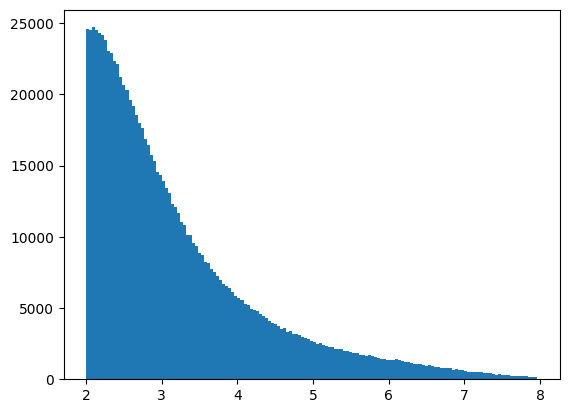

In [20]:
binwidth = 0.04 #The channel energy width is 0.04
ISpectra = plt.hist(df['E_AVG'], bins = np.arange(2,8,binwidth) )

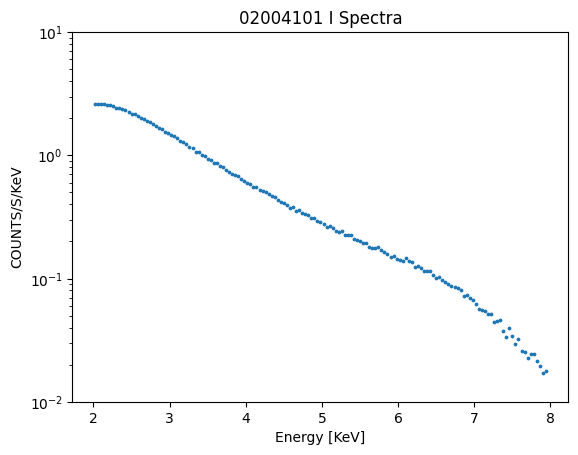

In [21]:
Counts = ISpectra[0]
CenterofISpectraBins = (ISpectra[1][:-1] + ISpectra[1][1:])/2

plt.figure()
plt.scatter(CenterofISpectraBins,Counts/LIVETIME/binwidth,s=3)
plt.xlabel('Energy [KeV]')
plt.ylabel('COUNTS/S/KeV')
plt.title(f'{OBSID} I Spectra')
plt.ylim(0.01,10)
plt.yscale('log')
fig1 = plt.gcf()
plt.show()
fig1.savefig(f'{path}/plots/CombinedISpectra.jpg')


## Seperate Spectra For Each Detector

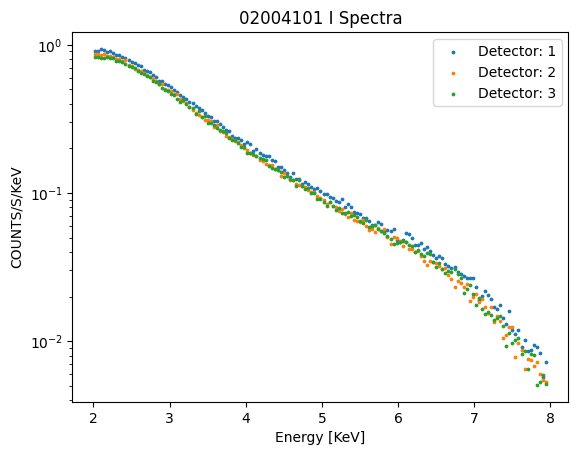

In [22]:
#Kislat 

binwidth = 0.04 #The channel energy width is 0.04
#ISpectra = plt.hist(df['E_AVG'], bins = np.arange(2,8,binwidth) )
plt.figure()
for det in range(1,3+1): #plus 1 so that we get all 3 detectors
    
    ISpectra = np.histogram(df['E_AVG'].loc[df['detector'] == det], bins = np.arange(2,8,binwidth) )
    Counts = ISpectra[0]
    CenterofISpectraBins = (ISpectra[1][:-1] + ISpectra[1][1:])/2

    
    plt.scatter(CenterofISpectraBins,Counts/LIVETIME/binwidth,s=3,label=f'Detector: {det}')
plt.xlabel('Energy [KeV]')
plt.ylabel('COUNTS/S/KeV')
plt.title(f'{OBSID} I Spectra')
#plt.ylim(0.01,10)
plt.yscale('log')
plt.legend()
fig1 = plt.gcf()
plt.show
fig1.savefig(f'{path}/plots/ISpectra.jpg')


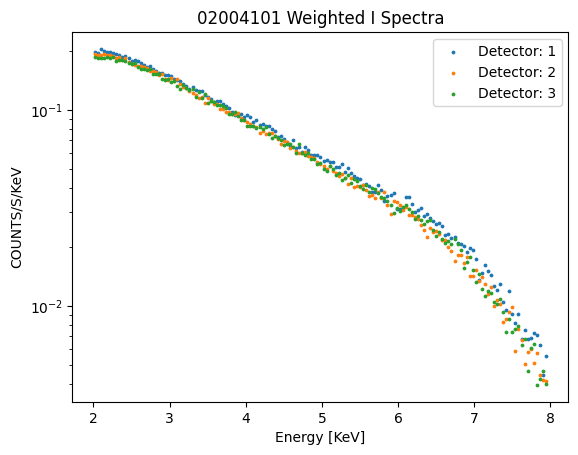

In [23]:
#Kislat A.2a

binwidth = 0.04 #The channel energy width is 0.04
#ISpectra = plt.hist(df['E_AVG'], bins = np.arange(2,8,binwidth) )
plt.figure()
for det in range(1,3+1): #plus 1 so that we get all 3 detectors
    
    ISpectra = np.histogram(df['E_AVG'].loc[df['detector'] == det], bins = np.arange(2,8,binwidth) )
    Counts = []
    for i in np.arange(2,8-binwidth,binwidth):
        C = df['W_mom'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].sum()
        Counts = np.append(Counts,C)
    CenterofISpectraBins = (ISpectra[1][:-1] + ISpectra[1][1:])/2

    
    plt.scatter(CenterofISpectraBins,Counts/LIVETIME/binwidth,s=3,label=f'Detector: {det}')
plt.xlabel('Energy [KeV]')
plt.ylabel('COUNTS/S/KeV')
plt.title(f'{OBSID} Weighted I Spectra')
#plt.ylim(0.01,10)
plt.yscale('log')
plt.legend()
fig1 = plt.gcf()
plt.show()
fig1.savefig(f'{path}/plots/WeightedISpectra.jpg')
plt.close()

## Weighted Q Spectra

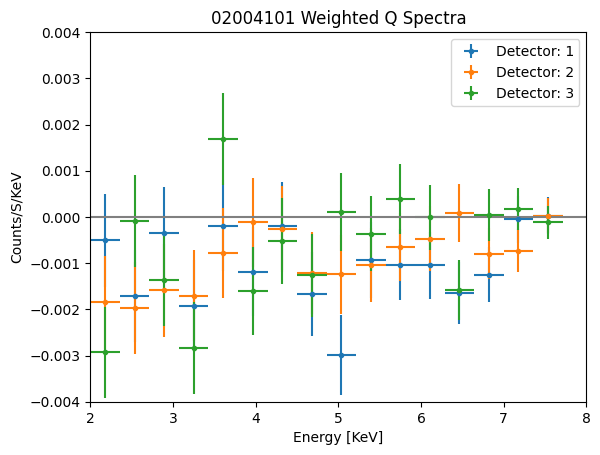

In [24]:
binwidth = 5/14 #The channel energy width is 0.04
#ISpectra = plt.hist(df['E_AVG'], bins = np.arange(2,8,binwidth) )
plt.figure()
for det in range(1,3+1): #plus 1 so that we get all 3 detectors
    
    ISpectra = np.histogram(df['E_AVG'].loc[df['detector'] == det], bins = np.arange(2,8,binwidth)  )
    CenterofISpectraBins = (ISpectra[1][:-1] + ISpectra[1][1:])/2
    Q = []
    Q_Wmom = []
    W_mom = []
    Qstd = []
    I = []
    binwidth_2 = binwidth/2
    #for i in np.arange(2,8-binwidth,binwidth):
    for i in CenterofISpectraBins:
        I_ = len(df['Q'].loc[df['E_AVG'].between(i-binwidth_2,i+binwidth_2)& (df['detector'] == det)])
        Q_ = df['Q'].loc[df['E_AVG'].between(i-binwidth,i+binwidth_2)& (df['detector'] == det)].sum()
        Q_std = df['Q'].loc[df['E_AVG'].between(i-binwidth,i+binwidth_2)& (df['detector'] == det)].std()
        Q_Wmom_ = df['Q*W_mom'].loc[df['E_AVG'].between(i-binwidth_2,i+binwidth_2)& (df['detector'] == det)].sum()
        Wmom_ = df['W_mom'].loc[df['E_AVG'].between(i-binwidth_2,i+binwidth_2)& (df['detector'] == det)].mean()
        Q = np.append(Q,Q_)
        Q_Wmom = np.append(Q_Wmom, Q_Wmom_)
        W_mom = np.append(W_mom,Wmom_)
        Qstd = np.append(Qstd,Q_std)
        I = np.append(I,I_)
    Counts_Sec_KEV = (Q/LIVETIME/binwidth)
    WeightedCounts_Sec_KEV = (Q_Wmom/LIVETIME/binwidth)
    Q_Wmom_std = np.sqrt(abs(Qstd**2)*I)*W_mom/LIVETIME/binwidth
    
    plt.errorbar(CenterofISpectraBins,WeightedCounts_Sec_KEV,yerr = Q_Wmom_std,xerr = binwidth/2,markersize=3,label=f'Detector: {det}',fmt='o')
plt.xlabel('Energy [KeV]')
plt.ylabel('Counts/S/KeV')
plt.title(f'{OBSID} Weighted Q Spectra')
plt.ylim(-0.004,0.004)
plt.hlines(0,2,8,color = 'grey')
plt.xlim(2,8)
#plt.yscale('log')
plt.legend()
fig1 = plt.gcf()
plt.show()
fig1.savefig(f'{path}/plots/WeightedQSpectra.jpg')
plt.close()

## Weighted U Spectra

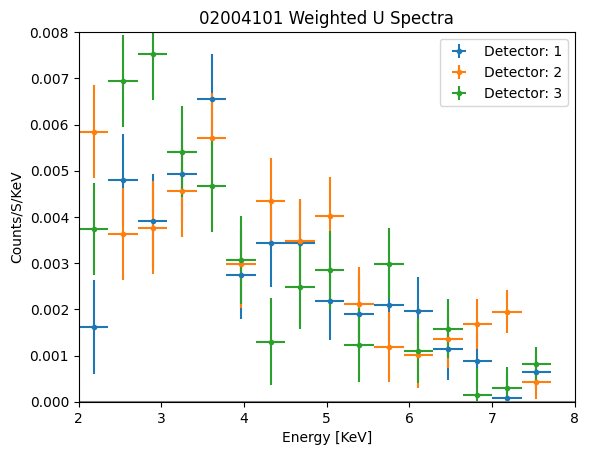

In [25]:
binwidth = 5/14#The channel energy width is 0.04 (5/14 matched old code)
#ISpectra = plt.hist(df['E_AVG'], bins = np.arange(2,8,binwidth) )
plt.figure()
for det in range(1,3+1): #plus 1 so that we get all 3 detectors
    
    ISpectra = np.histogram(df['E_AVG'].loc[df['detector'] == det], bins = np.arange(2,8,binwidth)  )
    CenterofISpectraBins = (ISpectra[1][:-1] + ISpectra[1][1:])/2
    I = []
    U = []
    U_Wmom = []
    W_mom = []
    Ustd = []
    for i in np.arange(2,8-binwidth,binwidth):
        I_ = len(df['U'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)])
        U_ = df['U'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].sum()
        U_std = df['U'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].std()
        U_Wmom_ = df['U*W_mom'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].sum()
        Wmom_ = df['W_mom'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].mean()
        U = np.append(U,U_)
        U_Wmom = np.append(U_Wmom, U_Wmom_)
        W_mom = np.append(W_mom,Wmom_)
        Ustd = np.append(Ustd,U_std)
        I = np.append(I,I_)
    Counts_Sec_KEV = (U/LIVETIME/binwidth)
    WeightedCounts_Sec_KEV = (U_Wmom/LIVETIME/binwidth)
    U_Wmom_std = np.sqrt(abs(Ustd**2)*I)*W_mom/LIVETIME/binwidth # I because that is the number of terms in our sum
    plt.errorbar(CenterofISpectraBins,WeightedCounts_Sec_KEV,yerr = U_Wmom_std,xerr = binwidth/2,markersize=3,label=f'Detector: {det}',fmt='o')
plt.xlabel('Energy [KeV]')
plt.ylabel('Counts/S/KeV')
plt.title(f'{OBSID} Weighted U Spectra')
plt.ylim(-0.00,0.008)
#plt.yscale('log')
plt.legend()
plt.hlines(0,2,8,color = 'grey')
plt.xlim(2,8)
fig1 = plt.gcf()
plt.show()
fig1.savefig(f'{path}/plots/WeightedUSpectra.jpg')
plt.close()

## Normalized Q and U Plot

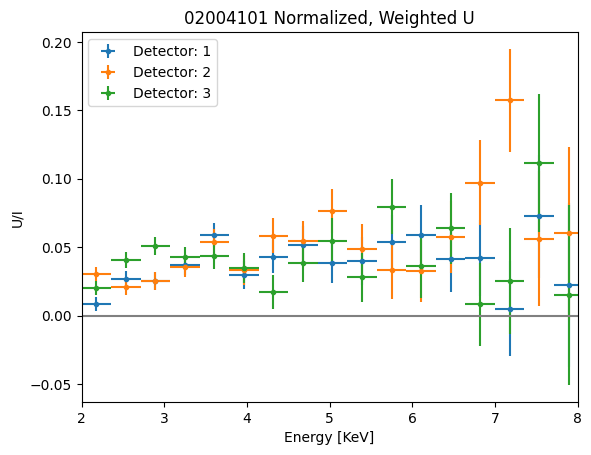

In [26]:
binwidth = 5/14 #The channel energy width is 0.04
#ISpectra = plt.hist(df['E_AVG'], bins = np.arange(2,8,binwidth) )
plt.figure()
for det in range(1,3+1): #plus 1 so that we get all 3 detectors    
    I_Wmom = []
    U_Wmom = []
    Energy = []
    Ustd = []
    I = []
    W_mom = []
    for i in np.arange(2,8,binwidth):
        CenterofISpectraBins_ = i +(binwidth/2) 
        I_ = df['W_mom'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].sum()
        U_Wmom_ = df['U*W_mom'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].sum()
        U_std = df['U'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].std()
        Wmom_ = df['W_mom'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)].mean()
        U_Wmom = np.append(U_Wmom, U_Wmom_)
        I_Wmom = np.append(I_Wmom, I_)
        Energy = np.append(Energy,CenterofISpectraBins_)
        Ustd = np.append(Ustd,U_std)
        W_mom = np.append(W_mom,Wmom_)
        I = np.append(I,len(df['U'].loc[df['E_AVG'].between(i,i+binwidth)& (df['detector'] == det)]))
    U_Wmom_std = np.sqrt(abs(Ustd**2)*I)
    U_Wmom_std = abs(np.sqrt(((abs(Ustd**2)*I*W_mom*W_mom)/(U_Wmom**2)) + ((I_Wmom**(1/4))/(I_Wmom**2)))*(U_Wmom/I_Wmom))
        
        
    plt.errorbar(Energy,U_Wmom/I_Wmom,markersize=3,yerr = U_Wmom_std,xerr = binwidth/2,label=f'Detector: {det}',fmt='o')
plt.legend()
plt.title(f'{OBSID} Normalized, Weighted U')
plt.ylabel('U/I')
plt.xlabel('Energy [KeV]')
plt.hlines(0,2,8,color = 'grey')
plt.xlim(2,8)
fig1 = plt.gcf()
plt.show()
fig1.savefig(f'{path}/plots/NormalizedWeightedU.jpg')
plt.close()

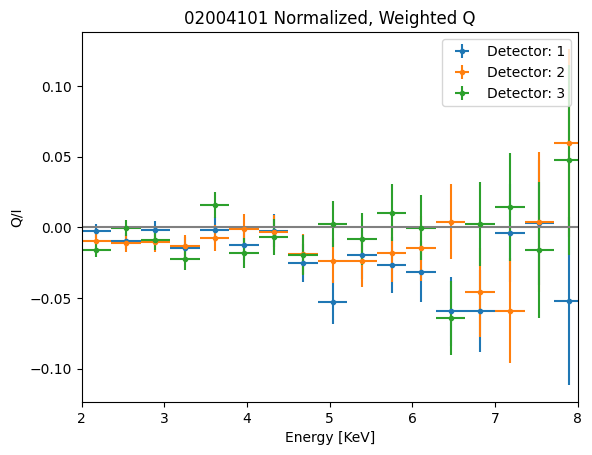

In [27]:
Ebinwidth = 5/14 #The channel energy width is 0.04
#ISpectra = plt.hist(df['E_AVG'], bins = np.arange(2,8,binwidth) )
plt.figure()
for det in range(1,3+1): #plus 1 so that we get all 3 detectors    
    I_Wmom = []
    Q_Wmom = []
    Energy = []
    Qstd = []
    I = []
    W_mom = []
    for i in np.arange(2,8,Ebinwidth):
        CenterofISpectraBins_ = i +(Ebinwidth/2) 
        I_ = df['W_mom'].loc[df['E_AVG'].between(i,i+Ebinwidth)& (df['detector'] == det)].sum()
        Q_Wmom_ = df['Q*W_mom'].loc[df['E_AVG'].between(i,i+Ebinwidth)& (df['detector'] == det)].sum()
        Q_std = df['Q'].loc[df['E_AVG'].between(i,i+Ebinwidth)& (df['detector'] == det)].std()
        Wmom_ = df['W_mom'].loc[df['E_AVG'].between(i,i+Ebinwidth)& (df['detector'] == det)].mean()
        Q_Wmom = np.append(Q_Wmom, Q_Wmom_)
        I_Wmom = np.append(I_Wmom, I_)
        Energy = np.append(Energy,CenterofISpectraBins_)
        Qstd = np.append(Qstd,Q_std)
        W_mom = np.append(W_mom,Wmom_)
        I = np.append(I,len(df['Q'].loc[df['E_AVG'].between(i,i+Ebinwidth)& (df['detector'] == det)]))
    Q_Wmom_std = np.sqrt(abs(Qstd**2)*I)
    Q_Wmom_std = abs(np.sqrt(((abs(Qstd**2)*I*W_mom*W_mom)/(Q_Wmom**2)) + ((I_Wmom**(1/4))/(I_Wmom**2)))*(Q_Wmom/I_Wmom))
        
        
    plt.errorbar(Energy,Q_Wmom/I_Wmom,markersize=3,yerr = Q_Wmom_std,xerr = Ebinwidth/2,label=f'Detector: {det}',fmt='o')
plt.legend()
plt.title(f'{OBSID} Normalized, Weighted Q')
plt.hlines(0,2,8,color = 'grey')
plt.xlim(2,8)
plt.ylabel('Q/I')
plt.xlabel('Energy [KeV]')
fig1 = plt.gcf()
fig1.savefig(f'{path}/plots/NormalizedWeightedQ.jpg')
plt.show()
#plt.savefig(f'/home/jacob/Desktop/HerX-1/{OBSID}/plots/NormalizedWeightedQ.pdf')
plt.close()

## Q VS U Plot

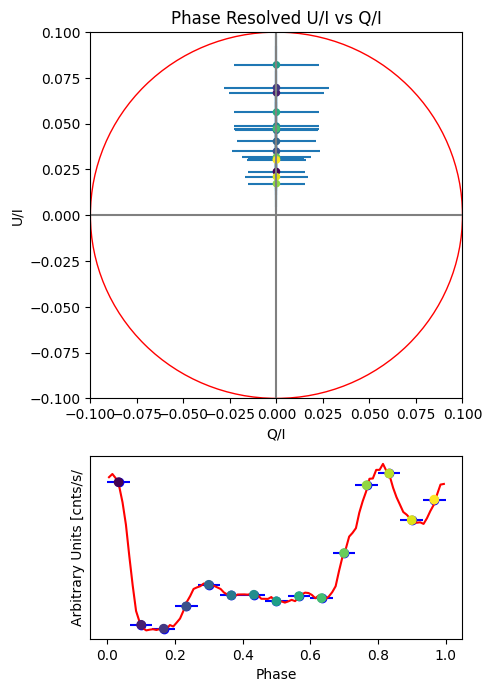

In [28]:
PBinWidth = 1/15
PhaseBins = np.arange(0,1+PBinWidth,PBinWidth)
#print(PhaseBins)
U = []
Q = []
Ustd = []
Qstd = []
W_mom = []
for i in np.arange(0,len(PhaseBins)-1,1):
    I = df['W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].sum()
    Wmom_ = df['W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].mean()
    resp = df['SPECRESP'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].mean()
    length = len(df.loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])])
    U_ = df['U*W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].sum()/I
    U = np.append(U,U_)
    Q_ = df['Q*W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].sum()/I
    Q = np.append(Q,Q_/I)
    U_std = (np.sqrt((1/length)*((2/(resp**2) - U_**2))))
    Q_std = (np.sqrt((1/length)*((2/(resp**2) - Q_**2))))
    PA_ = np.degrees((0.5)*np.arctan2(U_,Q_))
    PD_ = np.sqrt((U_**2)+(Q_**2))*100/resp  
    PDe = 100*np.sqrt(abs(2-(PD_/100*PD_/100*resp*resp))/((length-1)*resp*resp))

    PAe =abs(1/(PD_*resp/100)*(1/np.sqrt(2*length)))*180/np.pi
    Ustd = np.append(Ustd,U_std)
    Qstd = np.append(Qstd,Q_std)

fig,ax = plt.subplots(2,1,figsize=(5,7),gridspec_kw={'height_ratios':[3,1.5]})

#Draw circles at 10 and 20% polarization
circle = plt.Circle((0,0),0.1,fill = False,color = 'red',label ='10% Polarization')
ax[0].add_patch(circle) 
circle = plt.Circle((0,0),0.2,fill = False,color = 'green',label ='20% Polarization')
ax[0].add_patch(circle)

t = np.sin(PhaseBins[0:-1])
ax[0].errorbar(Q,U,yerr = Ustd, xerr= Qstd,fmt='o',markersize = 0)
ax[0].scatter(Q,U,s = 20,zorder=2,c=t)
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlim(-0.1,0.1)
ax[0].hlines(0,-1,1,color = 'grey')
ax[0].vlines(0,-1,1,color='grey')

ax[0].set_xlabel('Q/I')
ax[0].set_ylabel('U/I')
ax[0].set_title(f'Phase Resolved U/I vs Q/I')
#plt.legend()
#plt.savefig(f'/home/jacob/Desktop/HerX-1/{OBSID}/plots/PhaseResolveQU.pdf')






CenterofBins = (PulseP[1][:-1] + PulseP[1][1:])/2
PULSEP = np.array([CenterofBins,PulseP[0]]).T
PULSEP = pd.DataFrame(PULSEP, columns = ['Phase','Count'])
Count = np.empty(0)
CP = np.empty(0)
for i in range(len(PhaseBins)-1):
    CP_ = (PhaseBins[i]+ PhaseBins[i+1])/2
    CP = np.append(CP,CP_)
    Count = np.append(Count,PULSEP['Count'].loc[PULSEP['Phase'].between(CP_-0.01,CP_+0.01)].mean())

#plt.figure()
ax[1].plot(CenterofBins,PulseP[0]/LIVETIME,color='red')

ax[1].scatter(CP,Count/LIVETIME, c = t,zorder=2)
ax[1].errorbar(CP,Count/LIVETIME,xerr = PBinWidth/2,color='blue',fmt='o',zorder=1)

ax[1].set_xlabel('Phase')
ax[1].tick_params(left = False,labelleft = False)
ax[1].set_ylabel('Arbitrary Units [cnts/s/')
#ax[1].set_title(f'Pulse Profile')
#plt.ylim(0,0.06)

#ax[0].set_aspect('equal')
#ax[1].set_aspect('equal')
plt.tight_layout(pad = 1)
fig1 = plt.gcf()
plt.show
fig1.savefig(f'{path}/plots/QUPlot_PulseP.jpg')
#plt.close()



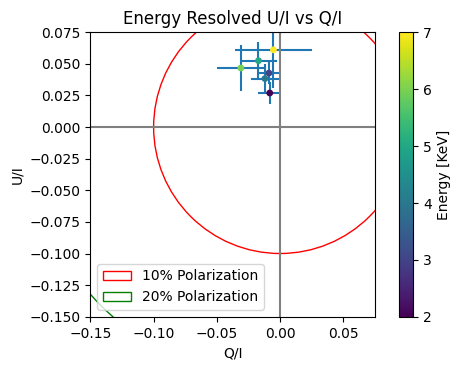

2.103890127634691 -0.6004778480182201


In [31]:
EBinWidth = 1
U = []
Q = []
Ustd = []
Qstd = []
W_mom = []
for i in np.arange(2,8,EBinWidth):
    I = df['W_mom'].loc[df['E_AVG'].between(i,i+EBinWidth)].sum()
    Wmom_ = df['W_mom'].loc[df['E_AVG'].between(i,i+EBinWidth)].mean()
    length = len(df.loc[df['E_AVG'].between(i,i+EBinWidth)])
    U_ = df['U*W_mom'].loc[df['E_AVG'].between(i,i+EBinWidth)].sum()/I
    Q_ = df['Q*W_mom'].loc[df['E_AVG'].between(i,i+EBinWidth)].sum()/I
    resp = df['SPECRESP'].loc[df['E_AVG'].between(i,i+EBinWidth)].mean()
    U = np.append(U,U_)
    #Ustd_ = df['U'].loc[df['E_AVG'].between(i,i+EBinWidth)].std()

    length = len(df.loc[df['E_AVG'].between(i,i+EBinWidth)])
    PA_ = np.degrees((0.5)*np.arctan2(U_,Q_))
    PD_ = np.sqrt((U_**2)+(Q_**2))*100/resp   
    U_std = (np.sqrt((1/length)*((2/(resp**2) - U_**2))))
    Q_std = (np.sqrt((1/length)*((2/(resp**2) - Q_**2))))
    PDe = 100*np.sqrt(abs(2-(PD_/100*PD_/100*resp*resp))/((length-1)*resp*resp))

    PAe =abs(1/(PD_*resp/100)*(1/np.sqrt(2*length)))*180/np.pi

    Ustd = np.append(Ustd,U_std)
    #Ustd = np.append(Ustd, np.sqrt((((Ustd_/I)**2))*I))
    
    

    Q = np.append(Q,Q_)
    #Qstd_ = df['Q'].loc[df['E_AVG'].between(i,i+EBinWidth)].std()

    
    
    #Qstd = np.append(Qstd, np.sqrt((((Qstd_/I)**2))*I))
    Qstd = np.append(Qstd,Q_std)
fig,ax = plt.subplots(2,1,figsize=(6,7))

#Draw circles at 10 and 20% polarization
circle = plt.Circle((0,0),0.1,fill = False,color = 'red',label ='10% Polarization')
ax[0].add_patch(circle) 
circle = plt.Circle((0,0),0.2,fill = False,color = 'green',label ='20% Polarization')
ax[0].add_patch(circle)

t = np.arange(2,8,EBinWidth)
ax[0].errorbar(Q,U,yerr = Ustd, xerr= Qstd,fmt='o',markersize = 0)
ax[0].scatter(Q,U,s = 15,zorder=2,c=t)
ax[0].set_ylim(-15/100,7.5/100)
ax[0].set_xlim(-15/100,7.5/100)
ax[0].hlines(0,-100,100,color = 'grey')
ax[0].vlines(0,-100,100,color='grey')

ax[0].set_xlabel('Q/I')
ax[0].set_ylabel('U/I')
ax[0].set_title(f'Energy Resolved U/I vs Q/I')
ax[0].legend(loc='lower left')
mappable= ax[1].scatter(np.arange(2,8,EBinWidth),np.full(len(np.empty_like(np.arange(2,8,EBinWidth))),0),c=t)
#ax[1].set_xlabel('Energy [KeV]')
plt.tight_layout(pad=1)

children = fig1.get_children()[1]
#cset = ax[0].contourf(Q,U,t,)
fig.colorbar(mappable,ax=ax[0],label='Energy [KeV]')
ax[1].set_visible(False)
ax[0].set_aspect('equal',adjustable='box')
#fig.text(0.65,0.92,f'NH = 3E23')
fig1 = plt.gcf()
plt.show()
fig1.savefig(f'{path}/plots/EnergyResolveQU.jpg')
plt.close()

I = len(df['U'].loc[df['E_AVG'].between(2,3)])
U = df['U'].loc[df['E_AVG'].between(2,3)].sum()/I
Q = df['Q'].loc[df['E_AVG'].between(2,3)].sum()/I
print(U*100,Q*100)



## Phase Resolved Polarization Angle and Degree

[52.5095608]
[14.62031725]
2.0472970291616854


/tmp/ipykernel_85600/1709344612.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[3].plot(x,np.full(100,constant(x,constantfitPD)) ,label=[f'constant:{float(np.round(constantfitPD,2))}'u"\u00B1"f'{float(np.round(np.sqrt(covariancematrixPD[0,0]),2))}'])
/tmp/ipykernel_85600/1709344612.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[4].plot(x,np.full(100,constant(x,constantfitPA)),label=[f'constant:{float(np.round(constantfitPA,2))}'u"\u00B1"f'{float(np.round(np.sqrt(covariancematrixPA[0,0]),2))}'])


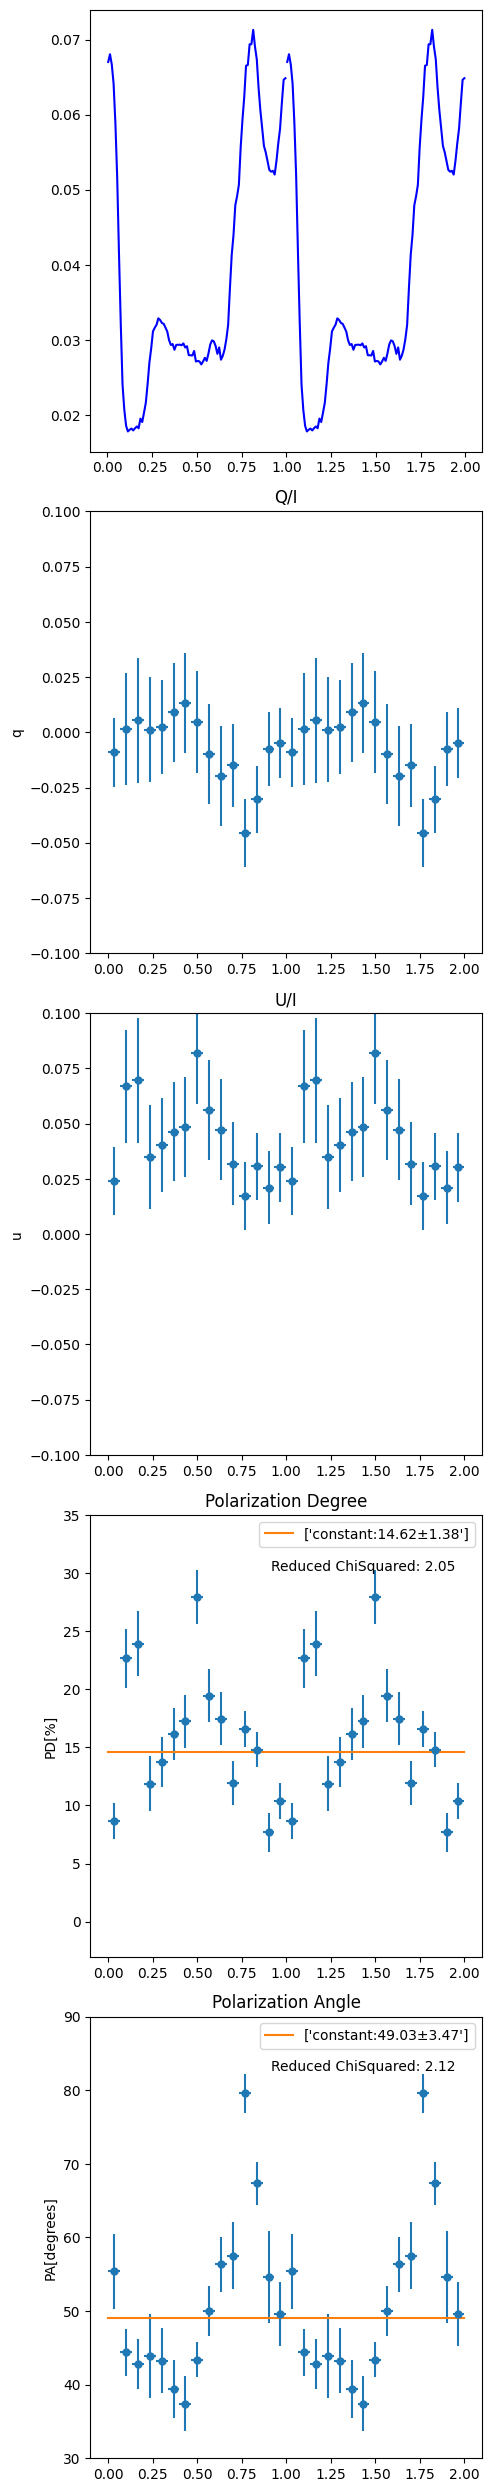

0.2934254120903038


In [45]:
df['U*W_mom*ModF'] = df['U*W_mom'] / df['SPECRESP']
df['Q*W_mom*ModF'] = df['Q*W_mom'] / df['SPECRESP']
meanModF = df['SPECRESP'].mean()

PA = []
PD = []
U_ = []
Q_ = []
E_ = []
Ustd = []
Qstd = []
Phase = []
Wmom = []
resp_ = []
PDE= np.empty(0)
PAE = np.empty(0)

PBinWidth = 2/30
PhaseBins = np.arange(0,1+PBinWidth,PBinWidth)


for i in range(len(PhaseBins)-1):
    I = df['W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].sum()
    Wmom_ = df['W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].mean()
    meanModF = df['SPECRESP'].mean()
    respstd = df['SPECRESP'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].std()
    resp = df['SPECRESP'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].mean()
    length = len(df.loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])])
    
    E = df['E_AVG'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].mean()
    U = df['U*W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].sum()/I
    Q = df['Q*W_mom'].loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])].sum()/I

    length = len(df.loc[df['Phase'].between(PhaseBins[i],PhaseBins[i+1])])
    PA_ = np.degrees((0.5)*np.arctan2(U,Q))
    PD_ = np.sqrt((U**2)+(Q**2))*100/resp   
    U_std = (np.sqrt((1/length)*((2/(resp**2) - U**2))))
    Q_std = (np.sqrt((1/length)*((2/(resp**2) - Q**2))))
    PDe = 100*np.sqrt(abs(2-(PD_/100*PD_/100*resp*resp))/((length-1)*resp*resp))

    PAe =abs(1/(PD_*resp/100)*(1/np.sqrt(2*length)))*180/np.pi


    
    #PDe = np.sqrt(np.sqrt((U**2)+(Q**2))*100/resp)
    #PAe = np.sqrt(np.degrees((0.5)*np.arctan2(U,Q)))
    #Resp only goes on PD, In PA it would get canceled in the ratio of U and Q.
    PA_ = np.degrees((0.5)*np.arctan2(U,Q))
    #if PA_ < 0:
    #    PA_ = PA_ +180
    PA = np.append(PA,PA_)
    PD = np.append(PD,np.sqrt((U**2)+(Q**2))*100/resp)
    PDE = np.append(PDE,abs(PDe))
    PAE = np.append(PAE,abs(PAe))
    Phase = np.append(Phase,(PhaseBins[i]+PhaseBins[i+1])/2)
    #PDE = np.sqrt(abs(PD))
    #PAE = np.sqrt(abs(PA))
    U_ = np.append(U_,U)
    Q_ = np.append(Q_,Q)
    E_ = np.append(E_,E)
    resp_ = np.append(resp_,resp)
    Wmom = np.append(Wmom,Wmom_)
    Ustd = np.append(Ustd,U_std)#np.sqrt(abs(U))*Wmom_*resp)
    Qstd = np.append(Qstd,Q_std)#np.sqrt(abs(Q))*Wmom_*resp)
#PDtest = []
#for i in range(len(Phase)):
#    x = 2*100**np.sqrt(((U_[i])**2)+((Q_[i])**2))
#    PDtest.append(x)
#print(PDtest)
#print(PDtest)
#print(Phase)
#PDtest.append(PDtest)
def constant(x,a):
    return a
    
constantfitPD,covariancematrixPD = opt.curve_fit(constant,Phase,PD,sigma = PDE)
constantfitPA,covariancematrixPA = opt.curve_fit(constant,Phase,PA,sigma = PAE)
print(constantfitPA)

def MinChiSquared(a):
    return abs((np.sum((((PD - a))**2)/PD)/14) - 1)
PDx2 = opt.minimize(MinChiSquared,constantfitPD,method = 'nelder-mead')

#constantfitPD = PDx2.x
PDFitX2 = abs(np.sum((((PD - constantfitPD))**2)/PD)/14)

print(constantfitPD)
print(PDFitX2)

def MinChiSquared(a):
    return abs((np.sum((((PA - a))**2)/PA)/14) - 1)
PAx2 = opt.minimize(MinChiSquared,constantfitPA,method = 'nelder-mead')

constantfitPA = PAx2.x
#print(constantfitPA)
PAFitX2 = abs(np.sum((((PA - constantfitPA))**2)/PA))/14

#def MinChiSquaredPA(a):
#    return abs((np.sum((((PA[0:14] - a))**2)/PA[0:14])/14) - 1)
#res = opt.minimize(MinChiSquaredPA,constantfitPA)
#constantfitPA = res.x
#print(constantfitPA)
#PAFitX2 = MinChiSquared(res.x)

def ChiSquared(xdata,fit,ydata,ysigma):
    r = constant(xdata,fit)-ydata
    x_2 = np.sum((r/ysigma)**2)

    chi_squared_stat = (((r)**2)/ydata).sum()

    
    return chi_squared_stat/(len(xdata)-1)

#PDFitX2 = np.sum((((PD[0:14] - constantfitPD))**2)/PD[0:14])/14#ChiSquared(Phase,constantfitPD,PD,PDE)#covariancematrixPD[0,0])
#print(PDFitX2)
#PDFitX1 = scipy.stats.chisquare(PA,np.full_like(PA,constantfitPA[0]))
#print(PDFitX1)

#PAFitX2 = np.sum((((PA[0:14] - constantfitPA))**2)/PA[0:14])/14#ChiSquared(Phase,constantfitPA,PA,PAE)#covariancematrixPA[0,0])
#print(PAFitX2)

#Plot everything twice
Phase = np.append(Phase,Phase+1)
PA = np.append(PA,PA)
PD = np.append(PD,PD)
PDE = np.append(PDE,abs(PDE))
PAE = np.append(PAE,abs(PAE))
U_ = np.append(U_,U_)
Q_ = np.append(Q_,Q_)
E_ = np.append(E_,E_)
Ustd = np.append(Ustd,Ustd)
Qstd = np.append(Qstd,Qstd)
resp_ = np.append(resp_,resp_)
Wmom = np.append(Wmom,Wmom)


fig,ax = plt.subplots(5,1,figsize=(5,25))

ax[0].plot(CenterofBins,PulseP[0]/LIVETIME,color='blue')
ax[0].plot(CenterofBins+1,PulseP[0]/LIVETIME,color='blue')

ax[2].errorbar(Phase,U_,xerr=PBinWidth/2,yerr = Ustd,fmt='o',markersize=5)
ax[2].set_title('U/I')
ax[2].set_ylabel('u')
ax[2].set_ylim(-0.1,0.1)

ax[1].errorbar(Phase,Q_,xerr=PBinWidth/2,fmt='o',yerr=Qstd,markersize=5)
ax[1].set_title('Q/I')
ax[1].set_ylabel('q')
ax[1].set_ylim(-0.1,0.1)

ax[3].errorbar(Phase,PD,xerr=PBinWidth/2,yerr=PDE,fmt='o',markersize=5)
x = np.linspace(0,2,100)
ax[3].plot(x,np.full(100,constant(x,constantfitPD)) ,label=[f'constant:{float(np.round(constantfitPD,2))}'u"\u00B1"f'{float(np.round(np.sqrt(covariancematrixPD[0,0]),2))}'])
fig.text(0.55,0.37,f'Reduced ChiSquared: {float(np.round(PDFitX2,2))}')
ax[3].set_title('Polarization Degree')
ax[3].set_ylabel('PD[%]')
ax[3].set_ylim(-3,35)
ax[3].legend()



ax[4].errorbar(Phase,PA,xerr=PBinWidth/2,yerr=PAE,fmt='o',markersize=5)
ax[4].plot(x,np.full(100,constant(x,constantfitPA)),label=[f'constant:{float(np.round(constantfitPA,2))}'u"\u00B1"f'{float(np.round(np.sqrt(covariancematrixPA[0,0]),2))}'])
ax[4].set_title('Polarization Angle')
fig.text(0.55,0.17,f'Reduced ChiSquared: {float(np.round(PAFitX2,2))}')
ax[4].set_ylabel('PA[degrees]')
ax[4].set_ylim(30,90)

plt.tight_layout(pad=1)
plt.legend()
fig1=plt.gcf()
plt.show()
fig1.savefig(f'{path}/Polarization&PulseProfile.jpg')

print(resp_.mean())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[53.12712491]
[12.06260127]
0.035937740297727595


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


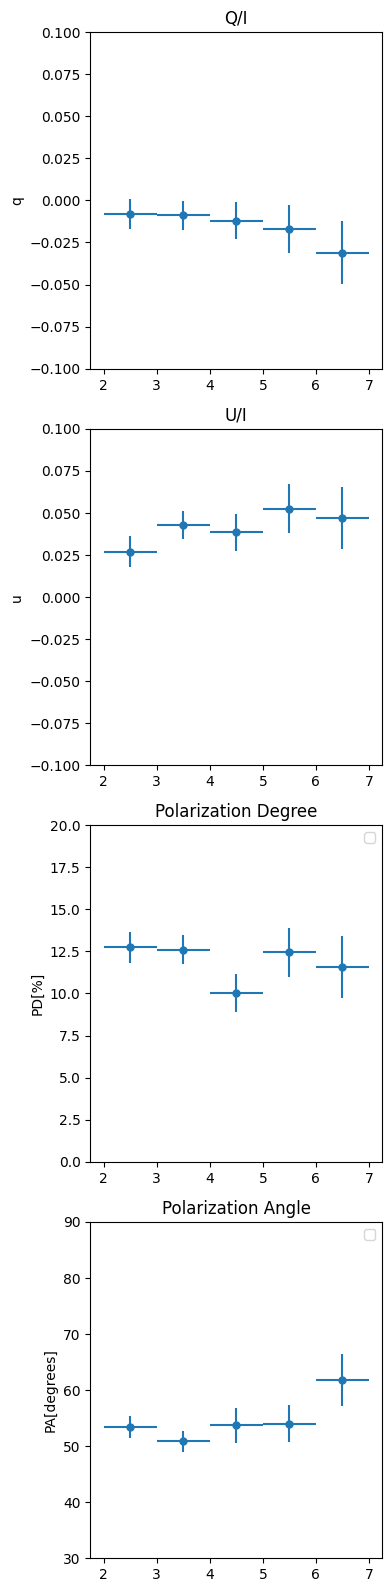

In [46]:
df['U*W_mom*ModF'] = df['U*W_mom'] / df['SPECRESP']
df['Q*W_mom*ModF'] = df['Q*W_mom'] / df['SPECRESP']
meanModF = df['SPECRESP'].mean()

PA = []
PD = []
U_ = []
Q_ = []
E = []
Ustd = []
Qstd = []
Phase = []
Wmom = []
resp_ = []
PDE= np.empty(0)
PAE = np.empty(0)
EBins = np.arange(2,8,EBinWidth)
for i in range(len(EBins)-1):
    I = df['W_mom'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].sum()
    Wmom_ = df['W_mom'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].mean()
    meanModF = df['SPECRESP'].mean()
    length = len(df.loc[df['E_AVG'].between(EBins[i],EBins[i+1])])
    
    respstd = df['SPECRESP'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].std()
    resp = df['SPECRESP'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].mean()
        
    #E = df['E_AVG'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].mean()
    U = df['U*W_mom'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].sum()/I
    Q = df['Q*W_mom'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].sum()/I
    
    PA_ = np.degrees((0.5)*np.arctan2(U,Q))
    PD_ = np.sqrt((U**2)+(Q**2))*100/resp   
    U_std = (np.sqrt((1/length)*((2/(resp**2) - U**2))))
    Q_std = (np.sqrt((1/length)*((2/(resp**2) - Q**2))))
    
    
    PDe = 100*np.sqrt(abs(2-(PD_/100*PD_/100*resp*resp))/((length-1)*resp*resp))

    PAe =abs(1/(PD_*resp/100)*(1/np.sqrt(2*length)))*180/np.pi
    
    #PDe = np.sqrt(np.sqrt((U**2)+(Q**2))*100/resp)
    #PAe = np.sqrt(np.degrees((0.5)*np.arctan2(U,Q)))

    PA_ = np.degrees((0.5)*np.arctan2(U,Q))
    #if PA_ < 0:
    #    PA_ = PA_ +180
    PA = np.append(PA,PA_)
    PD = np.append(PD,np.sqrt((U**2)+(Q**2))*100/resp)
    PDE = np.append(PDE,abs(PDe))
    PAE = np.append(PAE,abs(PAe))
    #Phase = np.append(Phase,(PhaseBins[i]+PhaseBins[i+1])/2)
    E = np.append(E,EBins[i] + EBinWidth/2)
    #PDE = np.sqrt(abs(PD))
    #PAE = np.sqrt(abs(PA))
    U_ = np.append(U_,U)
    Q_ = np.append(Q_,Q)
    E_ = np.append(E_,E)
    resp_ = np.append(resp_,resp)
    Wmom = np.append(Wmom,Wmom_)
    Ustd = np.append(Ustd,abs(U_std))#np.sqrt(abs(U))*Wmom_*resp)
    Qstd = np.append(Qstd,abs(Q_std))#np.sqrt(abs(Q
def constant(x,a):
    return a
    
constantfitPD,covariancematrixPD = opt.curve_fit(constant,EBins,PD,sigma = PDE)
constantfitPA,covariancematrixPA = opt.curve_fit(constant,EBins,PA,sigma = PAE)
print(constantfitPA)

def MinChiSquared(a):
    return abs((np.sum((((PD - a))**2)/PD)/14) - 1)
PDx2 = opt.minimize(MinChiSquared,constantfitPD,method = 'nelder-mead')

#constantfitPD = PDx2.x
PDFitX2 = abs(np.sum((((PD - constantfitPD))**2)/PD)/14)

print(constantfitPD)
print(PDFitX2)

def MinChiSquared(a):
    return abs((np.sum((((PA - a))**2)/PA)/14) - 1)
PAx2 = opt.minimize(MinChiSquared,constantfitPA,method = 'nelder-mead')

#constantfitPA = PAx2.x
#print(constantfitPA)
PAFitX2 = abs(np.sum((((PA - constantfitPA))**2)/PA))/14

#def MinChiSquaredPA(a):
#    return abs((np.sum((((PA[0:14] - a))**2)/PA[0:14])/14) - 1)
#res = opt.minimize(MinChiSquaredPA,constantfitPA)
#constantfitPA = res.x
#print(constantfitPA)
#PAFitX2 = MinChiSquared(res.x)

def ChiSquared(xdata,fit,ydata,ysigma):
    r = constant(xdata,fit)-ydata
    x_2 = np.sum((r/ysigma)**2)

    chi_squared_stat = (((r)**2)/ydata).sum()

    
    return chi_squared_stat/(len(xdata)-1)

#PDFitX2 = np.sum((((PD[0:14] - constantfitPD))**2)/PD[0:14])/14#ChiSquared(Phase,constantfitPD,PD,PDE)#covariancematrixPD[0,0])
#print(PDFitX2)
#PDFitX1 = scipy.stats.chisquare(PA,np.full_like(PA,constantfitPA[0]))
#print(PDFitX1)

#PAFitX2 = np.sum((((PA[0:14] - constantfitPA))**2)/PA[0:14])/14#ChiSquared(Phase,constantfitPA,PA,PAE)#covariancematrixPA[0,0])
#print(PAFitX2)

fig,ax = plt.subplots(4,1,figsize=(4,16))

#ax[0].plot(CenterofBins,PulseP[0]/LIVETIME,color='blue')
#ax[0].plot(CenterofBins+1,PulseP[0]/LIVETIME,color='blue')

ax[1].errorbar(E,U_,xerr=EBinWidth/2,yerr = Ustd,fmt='o',markersize=5)
ax[1].set_title('U/I')
ax[1].set_ylabel('u')
ax[1].set_ylim(-0.1,0.1)

ax[0].errorbar(E,Q_,xerr=EBinWidth/2,fmt='o',yerr=Qstd,markersize=5)
ax[0].set_title('Q/I')
ax[0].set_ylabel('q')
ax[0].set_ylim(-0.1,0.1)

ax[2].errorbar(E,PD,xerr=EBinWidth/2,yerr=PDE,fmt='o',markersize=5)
x = np.linspace(2,8,100)
#ax[2].plot(x,np.full(100,constant(x,constantfitPD)) ,label=[f'constant:{float(np.round(constantfitPD,2))}'u"\u00B1"f'{float(np.round(np.sqrt(covariancematrixPD[0,0]),2))}'])
#fig.text(0.45,0.45,f'Reduced ChiSquared: {float(np.round(PDFitX2,2))}')
ax[2].set_title('Polarization Degree')
ax[2].set_ylabel('PD[%]')
ax[2].set_ylim(0,20)
ax[2].legend()


ax[3].errorbar(E,PA,xerr=EBinWidth/2,yerr=PAE,fmt='o',markersize=5)
#ax[3].plot(x,np.full(100,constant(x,constantfitPA)),label=[f'constant:{float(np.round(constantfitPA,2))}'u"\u00B1"f'{float(np.round(np.sqrt(covariancematrixPA[0,0]),2))}'])
ax[3].set_title('Polarization Angle')
#fig.text(0.45,0.20,f'Reduced ChiSquared: {float(np.round(PAFitX2,2))}')
ax[3].set_ylabel('PA[degrees]')
ax[3].set_ylim(30,90)

plt.tight_layout(pad=1)
plt.legend()
fig1=plt.gcf()
plt.show()
fig1.savefig(f'{path}/PolarizationvsEPlots.jpg')


2.5           0.2210341428774108
3.5           0.3457210573608187
4.5           0.40028085604071506
5.5           0.4436901782233344
6.5           0.4846101000201847


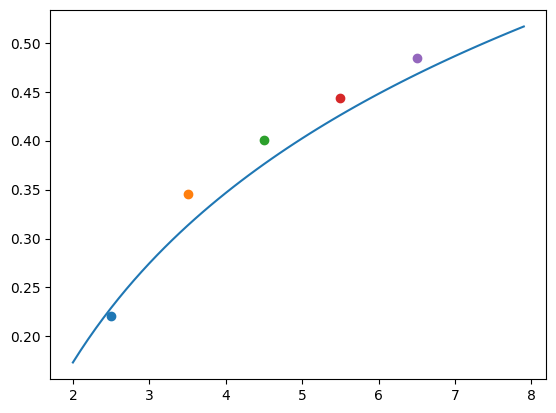

In [34]:
EBins = np.arange(2,8,1)
for i in range(len(EBins)-1):
    resp = df['SPECRESP'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].mean()
    print((EBins[i]+EBins[i+1])/2,'         ',resp)
    plt.scatter((EBins[i]+EBins[i+1])/2,resp)

span = np.arange(2,8,0.1)
plt.plot(span, 0.25*np.log(span))

In [35]:
EBins = [2,3,4,5]

PA = []
PD = []
PDE = []
PAE = []
Elow = []
Eh =[]
Counts = []
Rate = []
U_ = []
Q_ = []
Ustd = []
Qstd = []
for i in range(len(EBins)-1):
    Emin,Emax = EBins[i],EBins[i+1]
    
    I = df['W_mom'].loc[df['E_AVG'].between(Emin,Emax)].sum()
    Wmom_ = df['W_mom'].loc[df['E_AVG'].between(Emin,Emax)].mean()
    meanModF = df['SPECRESP'].mean()
    length = len(df.loc[df['E_AVG'].between(Emin,Emax)])
    W2 = df['W_mom'].loc[df['E_AVG'].between(Emin,Emax)]*df['W_mom'].loc[df['E_AVG'].between(Emin,Emax)]
    W2 = W2.sum()

    respstd = df['SPECRESP'].loc[df['E_AVG'].between(Emin,Emax)].std()
    resp = df['SPECRESP'].loc[df['E_AVG'].between(Emin,Emax)].mean()
        
    #E = df['E_AVG'].loc[df['E_AVG'].between(EBins[i],EBins[i+1])].mean()
    U = df['U*W_mom'].loc[df['E_AVG'].between(Emin,Emax)].sum()/I
    Q = df['Q*W_mom'].loc[df['E_AVG'].between(Emin,Emax)].sum()/I
    PA_ = np.degrees((0.5)*np.arctan2(U,Q))
    PD_ = np.sqrt((U**2)+(Q**2))*100/resp   
    U_std = (np.sqrt((1/length)*((2/(resp**2) - U**2))))
    Q_std = (np.sqrt((1/length)*((2/(resp**2) - Q**2))))
    
    PDe = 100*np.sqrt(abs(2-(PD_/100*PD_/100*resp*resp))/((length-1)*resp*resp))

    PAe =abs(1/(PD_*resp/100)*(1/np.sqrt(2*length)))*180/np.pi


    cnts = len(df.loc[df['E_AVG'].between(Emin,Emax)])
    rate = cnts/LIVETIME
    PD = np.append(PD,float(np.round(PD_,2)))
    PA = np.append(PA,float(np.round(PA_,2)))
    PDE = np.append(PDE,abs(float(np.round(PDe,2))))
    PAE = np.append(PAE,abs(float(np.round(PAe,2))))
    U_ = np.append(U_,U)
    Q_ = np.append(Q_,Q)
    Ustd = np.append(Ustd,abs(U_std))
    Qstd = np.append(Qstd,abs(Q_std))
    Elow = np.append(Elow,Emin)
    Eh = np.append(Eh,Emax)
    Rate = np.append(Rate,rate)
    Counts = np.append(Counts,cnts)
    print(f' Energy Bins: {Emin , Emax}keV  :  Polarization Degree: {np.round(PD_,2)}'u"\u00B1"f'{np.round(PDe,2)}  :  Counts: {cnts}  :  Rate: {rate}')
    print(f' Energy Bins: {Emin , Emax}keV  :  Polarization Angle: {np.round(PA_,2)}'u"\u00B1"f'{np.round(PAe,2)}  :  Counts: {cnts}  :  Rate: {rate}')
    print(resp)
dfPol = pd.DataFrame()
Pmin = 0
Pmax = 0.25
dfPol['Elow'] = Elow
dfPol['Emax'] = Eh
dfPol['PA'] = PA
dfPol['PAE'] = PAE
dfPol['PD'] = PD
dfPol['PDE'] = PDE
dfPol['TotalCounts'] = Counts
dfPol['Rate'] = Rate
dfPol['U'] = U_*100
dfPol['Q'] = Q_*100
dfPol['UE'] = Ustd*100
dfPol['QE'] = Qstd*100

dfPol.to_csv(f'{path}/{OBSID}EnergyPolarization.csv',index = False)
dfPol

 Energy Bins: (2, 3)keV  :  Polarization Degree: 12.74±0.9  :  Counts: 509219  :  Rate: 2.1529457929014524
 Energy Bins: (2, 3)keV  :  Polarization Angle: 53.42±2.02  :  Counts: 509219  :  Rate: 2.1529457929014524
0.2210341428774108
 Energy Bins: (3, 4)keV  :  Polarization Degree: 12.61±0.85  :  Counts: 232594  :  Rate: 0.9833927519478267
 Energy Bins: (3, 4)keV  :  Polarization Angle: 50.83±1.93  :  Counts: 232594  :  Rate: 0.9833927519478267
0.3457210573608187
 Energy Bins: (4, 5)keV  :  Polarization Degree: 10.03±1.12  :  Counts: 100017  :  Rate: 0.4228655634778446
 Energy Bins: (4, 5)keV  :  Polarization Angle: 53.67±3.19  :  Counts: 100017  :  Rate: 0.4228655634778446
0.40028085604071506


,Elow,Emax,PA,PAE,PD,PDE,TotalCounts,Rate,U,Q,UE,QE
0,2.0,3.0,53.42,2.02,12.74,0.90,509219.0,2.152946,2.694238,-0.815649,0.896602,0.896609
1,3.0,4.0,50.83,1.93,12.61,0.85,232594.0,0.983393,4.268531,-0.881102,0.848137,0.848182
2,4.0,5.0,53.67,3.19,10.03,1.12,100017.0,0.422866,3.832434,-1.196787,1.117089,1.117148


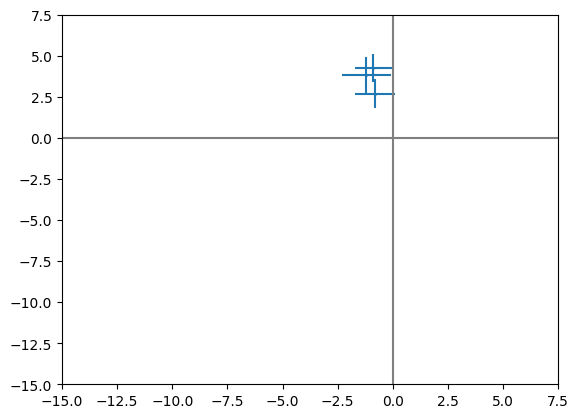

In [36]:
plt.errorbar(dfPol['Q'],dfPol['U'],yerr = dfPol['UE'],xerr=dfPol['QE'],fmt='o',markersize = 1)
plt.ylim(-15,7.5)
plt.xlim(-15,7.5)
plt.hlines(0,-100,100,color = 'grey')
plt.vlines(0,-100,100,color='grey')

In [ ]:
print(len(df)/LIVETIME)

In [ ]:
print(LIVETIME)